
# Plant project

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
import os
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input
from keras.callbacks import EarlyStopping
from keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\Amand\AppData\Local\Temp\ipykernel_98576\1433197705.py:9: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Functions

In [2]:
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

## Recurring variables

In [3]:
height = 256
width = 256
size_of_batch = 32
nr_of_classes = 30

## Load the dataset

In [4]:

data_path_train = r'data\split_ttv_dataset_type_of_plants\Train_Set_Folder'
data_path_val = r'data\split_ttv_dataset_type_of_plants\Validation_Set_Folder'
data_path_test = r'data\split_ttv_dataset_type_of_plants\Test_Set_Folder'


data_train = tf.keras.utils.image_dataset_from_directory(data_path_train) #, labels='inferred', label_mode='categorical', image_size=(height, width), batch_size=size_of_batch
data_val = tf.keras.utils.image_dataset_from_directory(data_path_val)
data_test = tf.keras.utils.image_dataset_from_directory(data_path_test)

train_labels = np.concatenate([y for x, y in data_train], axis=0)
val_labels = np.concatenate([y for x, y in data_val], axis=0)
test_labels = np.concatenate([y for x, y in data_test], axis=0)

data_train_iterator = data_train.as_numpy_iterator()
data_val_iterator = data_val.as_numpy_iterator()
data_test_iterator = data_test.as_numpy_iterator()

Found 23972 files belonging to 30 classes.
Found 3030 files belonging to 30 classes.
Found 2998 files belonging to 30 classes.


In [5]:
batch_train = data_train_iterator.next()
batch_val = data_val_iterator.next()
batch_test = data_test_iterator.next()

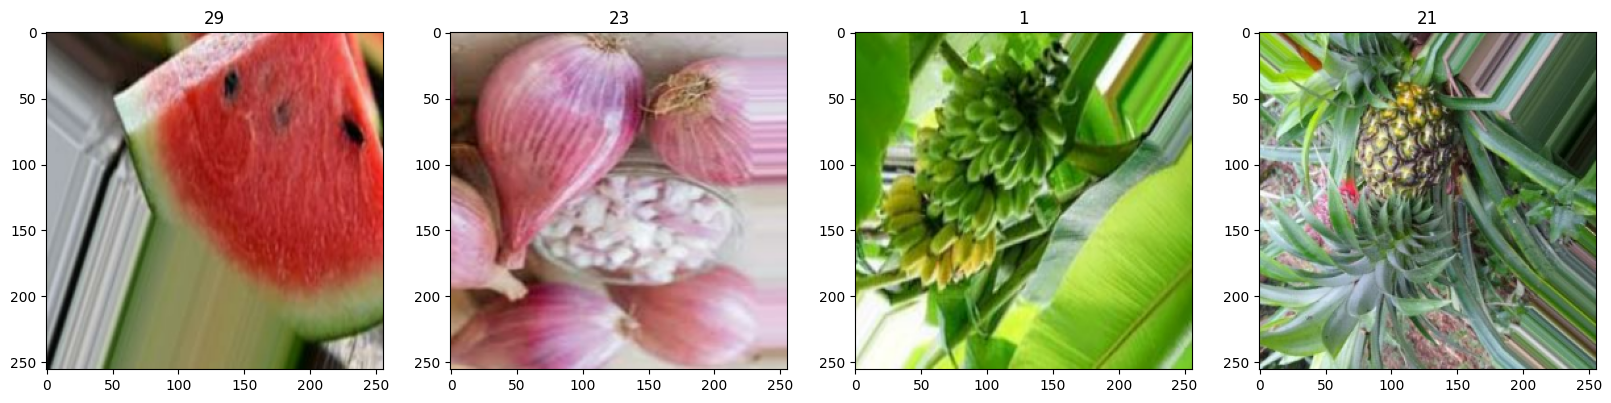

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_train[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch_train[1][idx])

## Scale the data

In [7]:
train = data_train.map(lambda x,y: (x/255, y))
val = data_val.map(lambda x,y: (x/255, y))
test = data_test.map(lambda x,y: (x/255, y))

In [8]:
train.as_numpy_iterator().next()
val.as_numpy_iterator().next()
test.as_numpy_iterator().next()

(array([[[[2.94111907e-01, 2.22405404e-01, 2.35288367e-01],
          [2.53333718e-01, 1.84987739e-01, 1.96750537e-01],
          [2.37928927e-01, 1.78218827e-01, 1.87530637e-01],
          ...,
          [7.08869457e-01, 8.50045979e-01, 7.40242064e-01],
          [7.08869457e-01, 8.50045979e-01, 7.40242064e-01],
          [7.08869457e-01, 8.50045979e-01, 7.40242064e-01]],
 
         [[2.48161763e-01, 1.92074522e-01, 1.90039068e-01],
          [2.16511562e-01, 1.67783007e-01, 1.63294658e-01],
          [2.13715911e-01, 1.68137252e-01, 1.62949979e-01],
          ...,
          [7.05882370e-01, 8.47058833e-01, 7.37254918e-01],
          [7.05882370e-01, 8.47058833e-01, 7.37254918e-01],
          [7.05882370e-01, 8.47058833e-01, 7.37254918e-01]],
 
         [[2.15019912e-01, 1.85772821e-01, 1.53421804e-01],
          [2.06518069e-01, 1.82820156e-01, 1.47694543e-01],
          [2.21587777e-01, 2.05242798e-01, 1.67666212e-01],
          ...,
          [7.01210201e-01, 8.42386663e-01, 7.3258

In [9]:
train

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Build the model

In [10]:
model = Sequential()

model.add(Input(shape=(height, width, 3)))

model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(nr_of_classes, activation='softmax'))

model.compile(optimizer=Adam(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,704,078 (14.13 MB)

 Trainable params: 3,704,078 (14.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 415s 551ms/step - accuracy: 0.2181 - loss: 2.6204 - val_accuracy: 0.4116 - val_loss: 1.8925
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - accuracy: 0.4523 - loss: 1.7229 - val_accuracy: 0.4990 - val_loss: 1.5959
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 179ms/step - accuracy: 0.5742 - loss: 1.3553 - val_accuracy: 0.5228 - val_loss: 1.5573
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - accuracy: 0.6762 - loss: 1.0058 - val_accuracy: 0.5327 - val_loss: 1.6072
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 133s 177ms/step - accuracy: 0.7799 - loss: 0.6768 - val_accuracy: 0.5228 - val_loss: 2.0064
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 389s 519ms/step - accuracy: 0.8698 - loss: 0.3958 - val_accuracy: 0.5145 - val_loss: 2.2835
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 134s 178ms/step - accuracy: 0.9091 - loss: 0.2825 - val_accuracy: 0.5073 - val_loss: 2.6919
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 133s 177ms/step - accuracy: 0.9427 -

In [14]:
model_name = "model-v1.h5"
model.save(model_name)

score = model.evaluate(test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.4484 - loss: 4.7205
Test Loss: 4.826422214508057
Test accuracy: 0.4543028771877289
